In [38]:
#**************** IMPORT PACKAGES ********************
from flask import Flask, render_template, request, flash, redirect, url_for
import pandas as pd
import numpy as np
from pandas import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math, random
from datetime import datetime
import datetime as dt
import json
import yfinance as yf
import statsmodels.tsa.arima.model as stats
import tweepy
import preprocessor as p
import re
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
# keras.layers import LSTM
import simplejson
from collections import deque
import random
from textblob import TextBlob
import constants as ct
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [41]:
def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year-2,end.month,end.day)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv(''+quote+'.csv')
    if(df.empty):
        from alpha_vantage.timeseries import TimeSeries
        ts = TimeSeries(key='N6A6QT6IBFJOPJ70',output_format='pandas')
        data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+quote, outputsize='full')
        #Format df
        #Last 2 yrs rows => 502, in ascending order => ::-1
        data=data.head(503).iloc[::-1]
        data=data.reset_index()
        #Keep Required cols only
        df=pd.DataFrame()
        df['Date']=data['date']
        df['Open']=data['1. open']
        df['High']=data['2. high']
        df['Low']=data['3. low']
        df['Close']=data['4. close']
        df['Adj Close']=data['5. adjusted close']
        df['Volume']=data['6. volume']
        df.to_csv(''+quote+'.csv',index=False)
    return

#******************** ARIMA SECTION ********************
def ARIMA_ALGO(df):
    from scipy.ndimage.interpolation import shift
    from pmdarima.arima import auto_arima
    import json
    uniqueVals = df["symbol"].unique()  
    len(uniqueVals)
    df=df.set_index("symbol")
    #for daily bas'is
    def parser(x):
        from datetime import datetime
        return datetime.strptime(x, '%Y-%m-%d')
    d['Date'] = pd.to_datetime(d['date']).map(lambda x: x.date())
    date = d.Date
    price = d.adjClose
    for company in uniqueVals[:10]:
        data=(df.loc[company,:]).reset_index() 
        data[['Code','Open','Low','High','Close','Adj_close','Date']] = data[['symbol','open','low','high','close', 'adjClose','date']]
        Quantity_date = data[['Code','Open','Low','High','Close','Adj_close', 'Date']]

        Quantity_date['Date'] = pd.to_datetime(Quantity_date['Date']).map(lambda x: x.date())
        Quantity_date = Quantity_date.fillna(Quantity_date.bfill())

        code = Quantity_date['Code'].to_list()
        close=Quantity_date['Close'].to_list()
        date=Quantity_date['Date'].to_list()
        open=Quantity_date['Open'].to_list()
        high=Quantity_date['High'].to_list()
        low=Quantity_date['Low'].to_list()
        Adj_close=Quantity_date['Adj_close'].to_list()

        close = pd.DataFrame(data = close, columns=["Close"])
        code = pd.DataFrame(data = code, columns=['Code'])
        date = pd.DataFrame(data = date, columns=["Date"]).astype(str)
        open = pd.DataFrame(data = open, columns=["Open"])
        high = pd.DataFrame(data = high, columns=["High"])
        low = pd.DataFrame(data = low, columns=["Low"])
        Adj_close = pd.DataFrame(data = Adj_close, columns=["Adj_close"])

        result = pd.concat([code, date, open, low, high, close, Adj_close], axis=1, ignore_index=True)

        result.columns = ['Code','Date','Open','Low','High','Close','Adj_close']

        Quantity_date = Quantity_date.drop(['Code','Date','Open','Low','High','Close'],axis =1)

        Quantity_date = Quantity_date.Adj_close
        print()
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(Quantity_date)
        plt.savefig('Trends.png')
        plt.close(fig)
        plt.show()
        import statsmodels.api as sm
        from statsmodels.tsa.stattools import adfuller    
        test_result=adfuller(Quantity_date)
        #Ho: It is non stationary
        #H1: It is stationary

        def adfuller_test(sales):
            result=adfuller(sales)
            labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
            for value,label in zip(result,labels):
                print(label+' : '+str(value) )
            if result[1] <= 0.05:
                print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
            else:
                print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        print(adfuller_test(Quantity_date))

        from pandas.plotting import autocorrelation_plot
        autocorrelation_plot(Quantity_date)
        plt.show()
        from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
        fig = plt.figure(figsize=(12,8))
        ax1 = fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(Quantity_date,ax=ax1)
        print(fig)
        ax2 = fig.add_subplot(212)
        fig = sm.graphics.tsa.plot_pacf(Quantity_date,ax=ax2)
        print(fig)
   
        quantity = Quantity_date.values
        size = int(len(quantity) * 0.65)
        train, test = quantity[0:size], quantity[size:len(quantity)]
        #fit in model
        
        model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                              test='adf',       # use adftest to find             optimal 'd'
                              max_p=3, max_q=3, # maximum p and q
                              m=1,              # frequency of series
                              d=None,           # let model determine 'd'
                              seasonal=False,   # No Seasonality
                              start_P=0, 
                              D=0, 
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)
        print(model_autoARIMA.summary())
        

        model_autoARIMA.plot_diagnostics(figsize=(15,8))
        plt.show()
        
        def arima_model(train, test):
            history = [x for x in train]
            predictions = [x for x in train]
            onlypreds = []
            for t in range(len(test)+7):
                model = stats.ARIMA(history, order=(0,1 ,0))
                model = model.fit()
                output = model.forecast()
                output = pd.DataFrame(output)
                yhat = output[0]
                predictions.append(yhat[0])
                onlypreds.append(yhat[0])
                if t < len(test):
                    obs = test[t]
                    history.append(obs)
                else:
                    obs = yhat[0]
                    history.append(obs)
            return predictions, onlypreds

        preds, onlypreds = arima_model(train, test)

        error_arima = math.sqrt(mean_squared_error(test, onlypreds[0:len(test)]))

        result["Date"] = result['Date'].astype(str).str.replace("-","/")
        x = np.append(train, onlypreds)

        pre = pd.DataFrame(x, columns=["ARIMA"])
        pre = pd.concat([pre, result['Adj_close']], axis=1)
        pre = pd.concat([pre, result['Date']], axis=1)

        idx = pd.date_range(np.array(result.Date)[-1], periods=8, freq='D')
        pre.Date[-8:] = idx.map(lambda x: x.date()).astype(str).str.replace("-","/")


        #plot graph
        print()
        #print("ARIMA model Accuracy: ")
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(result['Adj_close'], label='History')
        plt.plot(pre['Date'], pre["ARIMA"], label='Predicted')
        plt.legend(loc=4)
        plt.savefig('ARIMA.png')
        plt.close(fig)

        arima_test=quantity
        arima_predi=preds
        tomorrow_ar = arima_predi[-7]


        #plt.show()
        print()
        print("####arima_predi##########################################################################")
        print("Tomorrow's",quote," Closing Price Prediction by ARIMA:",tomorrow_ar )
        print("ARIMA RMSE:",error_arima)
        print("##############################################################################")
        print()
        prices = {"Date": date, "History": price, "Forecast": arima_predi}

        return arima_predi, error_arima, tomorrow_ar, result, pre



#**************** SENTIMENT ANALYSIS **************************
def retrieving_tweets_polarity(symbol):
    from tweepy.auth import OAuthHandler

    auth = OAuthHandler(ct.consumer_key, ct.consumer_secret)
    auth.set_access_token(ct.access_token, ct.access_token_secret)
    user = tweepy.API(auth)

    tweets = tweepy.Cursor(user.search_tweets, q=str(symbol), tweet_mode='extended', lang='en',exclude_replies=True).items(ct.num_of_tweets)

    tweet_list = [] #List of tweets alongside polarity
    global_polarity = 0 #Polarity of all tweets === Sum of polarities of individual tweets
    tw_list=[] #List of tweets only => to be displayed on web page
    #Count Positive, Negative to plot pie chart
    pos=0 #Num of pos tweets
    neg=1 #Num of negative tweets
    for tweet in tweets:
        count=20 #Num of tweets to be displayed on web page
        #Convert to Textblob format for assigning polarity
        tw2 = tweet.full_text
        tw = tweet.full_text
        #Clean
        tw=p.clean(tw)
        #print("-------------------------------CLEANED TWEET-----------------------------")
        #print(tw)
        #Replace &amp; by &
        tw=re.sub('&amp;','&',tw)
        #Remove :
        tw=re.sub(':','',tw)
        #print("-------------------------------TWEET AFTER REGEX MATCHING-----------------------------")
        #print(tw)
        #Remove Emojis and Hindi Characters
        tw=tw.encode('ascii', 'ignore').decode('ascii')

        #print("-------------------------------TWEET AFTER REMOVING NON ASCII CHARS-----------------------------")
        #print(tw)
        blob = TextBlob(tw)
        polarity = 0 #Polarity of single individual tweet
        for sentence in blob.sentences:

            polarity += sentence.sentiment.polarity
            if polarity>0:
                pos=pos+1
            if polarity<0:
                neg=neg+1

            global_polarity += sentence.sentiment.polarity
        if count > 0:
            tw_list.append(tw2)

        tweet_list.append(Tweet(tw, polarity))
        count=count-1
    global_polarity = global_polarity / len(tweet_list)
    neutral=ct.num_of_tweets-pos-neg
    if neutral<0:
        neg=neg+neutral
        neutral=20
    print()
    print("##############################################################################")
    print("Positive Tweets :",pos,"Negative Tweets :",neg,"Neutral Tweets :",neutral)
    print("##############################################################################")
    print()
    labels=['Positive','Negative','Neutral']
    sizes = [abs(pos),abs(neg),abs(neutral)]
    explode = (0, 0, 0)

    pie = pd.DataFrame(sizes, columns = ["sizes"])
    pie['labels'] = labels
    big_data = {"sizes": np.array(pie.sizes), "labels": np.array(pie.labels)}
    df2=pd.DataFrame(big_data)
    k = df2.to_dict('records')
    out_file = open("static/assets/js/dashboard/pie.json", "w", encoding='utf-8') 
    simplejson.dump(k, out_file, ensure_ascii=False, indent=4)


    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    fig1, ax1 = plt.subplots(figsize=(7.2,4.8),dpi=65)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig('static/SA.png')
    plt.close(fig)
    #plt.show()
    if global_polarity>0:
        print()
        print("##############################################################################")
        print("Tweets Polarity: Overall Positive")
        print("##############################################################################")
        print()
        tw_pol="Overall Positive"
    else:
        print()
        print("##############################################################################")
        print("Tweets Polarity: Overall Negative")
        print("##############################################################################")
        print()
        tw_pol="Overall Negative"
    return global_polarity,tw_list,tw_pol,pos,neg,neutral



def recommending(df, global_polarity,today_stock,mean):
    if today_stock.iloc[-1]['adjClose'] < mean:
        if global_polarity > 0:
            print()

            idea="RISE"
            decision="BUY"
            print()
            print("##############################################################################")
            print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
        elif global_polarity < 0:
            print()
            idea="FALL"
            decision="SELL"
            print()
            print("##############################################################################")
            print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
    else:
        print()
        idea="FALL"
        decision="SELL"
        print()
        print("##############################################################################")
        print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
    return idea, decision

##############################################################################
Today's AAPL Stock Data: 
     symbol                       date   close    high     low    open  \
1258   AAPL  2022-03-18 00:00:00+00:00  163.98  164.48  159.76  160.51   

         volume  adjClose  adjHigh  adjLow  adjOpen  adjVolume  divCash  \
1258  122055535    163.98   164.48  159.76   160.51  122055535      0.0   

      splitFactor  
1258          1.0  



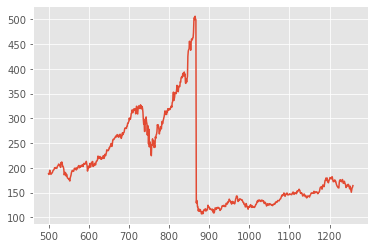

ADF Test Statistic : -0.6610191441674023
p-value : 0.856589800096941
#Lags Used : 1
Number of Observations Used : 757
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
None


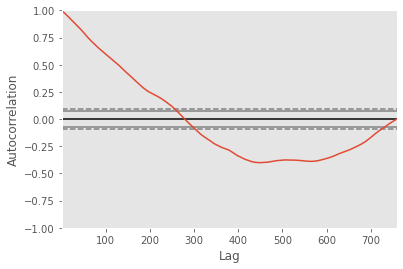

Figure(864x576)
Figure(864x576)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2110.029, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2104.423, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2104.967, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2111.191, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2105.936, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2106.033, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2107.936, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2106.395, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.515 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  493
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1049.212
Date:                Sun, 20 Mar 2022   AIC                           2104.423
Time

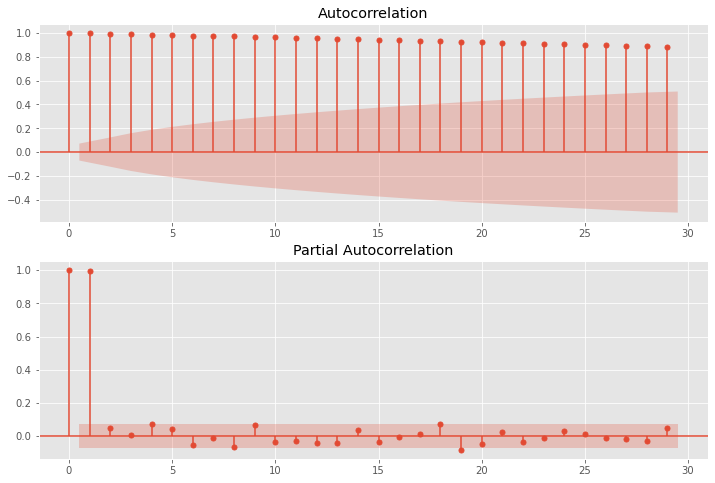

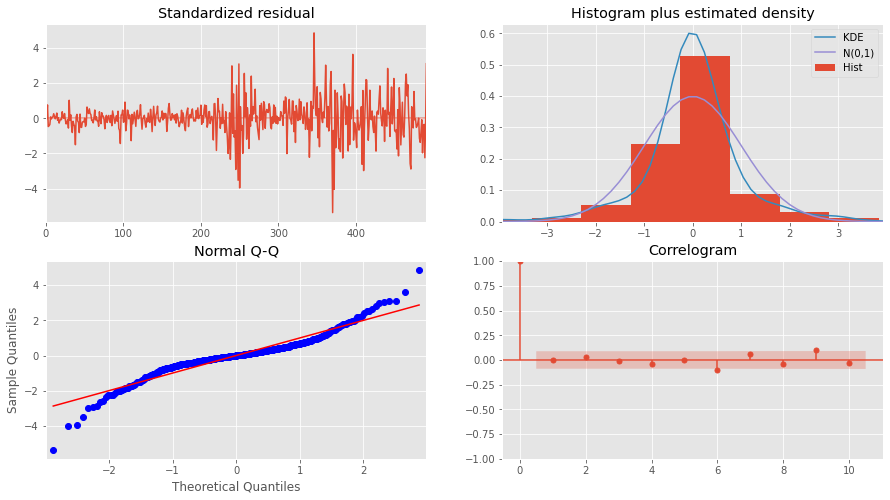

Unexpected parameter: exclude_replies



####arima_predi##########################################################################
Tomorrow's AAPL  Closing Price Prediction by ARIMA: 163.98
ARIMA RMSE: 2.3714228030845206
##############################################################################




Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies
Unexpected parameter: exclude_replies



##############################################################################
Positive Tweets : 159 Negative Tweets : 49 Neutral Tweets : 92
##############################################################################


##############################################################################
Tweets Polarity: Overall Positive
##############################################################################

ARIMA Model Forecasted Prices for Next 7 days:
[[163.98]
 [163.98]
 [163.98]
 [163.98]
 [163.98]
 [163.98]
 [163.98]]



##############################################################################
According to the DL Predictions and Sentiment Analysis of Tweets, a FALL in AAPL stock is expected:  SELL


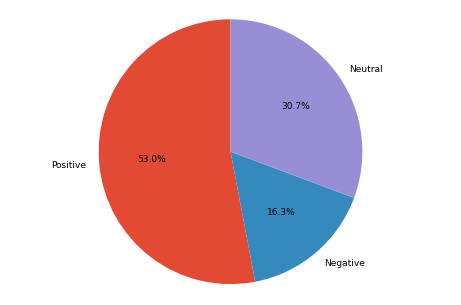

In [45]:

class Tweet(object):

    def __init__(self, content, polarity):
        self.content = content
        self.polarity = polarity


        
import pandas_datareader as pdr
quote = 'AAPL'
key="60104c377746149d341afb340c95833238fe5e73"
d = pdr.get_data_tiingo(quote, api_key=key)
d.dropna().to_csv(quote+'.csv')
d=pd.read_csv(quote+'.csv')
d = d[500:]
today_stock=d.iloc[-1:]
print("##############################################################################")
print("Today's",quote,"Stock Data: ")
print(today_stock)

plt.plot(d['close'])

#predictions
arima_predi, error_arima, tomorrow_ar, i, pre = ARIMA_ALGO(d)
# df3, error_lstm, tomorrow_lstm = LSTM_ALGO(d)

# df3 = pd.DataFrame(df3, columns = ["LSTM"])
df3 = pd.concat([pre.Date, pre.Adj_close], axis=1)
all_pred = pd.concat([df3, pre["ARIMA"]], axis=1)

print()
#print("Recent %s related Tweets & News: " % quote)
polarity,tw_list,tw_pol,pos,neg,neutral = retrieving_tweets_polarity(quote)
dates = np.array(all_pred["Date"].tail(7)).reshape(-1,1)
print("ARIMA Model Forecasted Prices for Next 7 days:")
forecast_set_ar = np.round(np.array(all_pred["ARIMA"].tail(7)),2).reshape(-1,1)
mean=d["adjClose"].tail(7).mean()
print(forecast_set_ar)
# print("LSTM Forecasted Prices for Next 7 days:")
# forecast_set_ls = np.round(np.array(all_pred["LSTM"].tail(7)), 2).reshape(-1,1)
# print(forecast_set_ls)
print()
#print("Generating recommendation based on prediction & polarity...")
idea, decision=recommending(i, polarity,today_stock,mean)
today_stock=today_stock.round(2)

In [35]:
print(pre)

None


In [ ]:


#**************** SENTIMENT ANALYSIS **************************
def retrieving_tweets_polarity(symbol):
    from tweepy.auth import OAuthHandler

    auth = OAuthHandler(ct.consumer_key, ct.consumer_secret)
    auth.access_token(ct.access_token, ct.access_token_secret)
    user = tweepy.API(auth)

    tweets = tweepy.Cursor(user.search_tweets, q=str(symbol), tweet_mode='extended', lang='en',exclude_replies=True).items(ct.num_of_tweets)

    tweet_list = [] #List of tweets alongside polarity
    global_polarity = 0 #Polarity of all tweets === Sum of polarities of individual tweets
    tw_list=[] #List of tweets only => to be displayed on web page
    #Count Positive, Negative to plot pie chart
    pos=0 #Num of pos tweets
    neg=1 #Num of negative tweets
    for tweet in tweets:
        count=20 #Num of tweets to be displayed on web page
        #Convert to Textblob format for assigning polarity
        tw2 = tweet.full_text
        tw = tweet.full_text
        #Clean
        tw=p.clean(tw)
        #print("-------------------------------CLEANED TWEET-----------------------------")
        #print(tw)
        #Replace &amp; by &
        tw=re.sub('&amp;','&',tw)
        #Remove :
        tw=re.sub(':','',tw)
        #print("-------------------------------TWEET AFTER REGEX MATCHING-----------------------------")
        #print(tw)
        #Remove Emojis and Hindi Characters
        tw=tw.encode('ascii', 'ignore').decode('ascii')

        #print("-------------------------------TWEET AFTER REMOVING NON ASCII CHARS-----------------------------")
        #print(tw)
        blob = TextBlob(tw)
        polarity = 0 #Polarity of single individual tweet
        for sentence in blob.sentences:

            polarity += sentence.sentiment.polarity
            if polarity>0:
                pos=pos+1
            if polarity<0:
                neg=neg+1

            global_polarity += sentence.sentiment.polarity
        if count > 0:
            tw_list.append(tw2)

        tweet_list.append(Tweet(tw, polarity))
        count=count-1
    global_polarity = global_polarity / len(tweet_list)
    neutral=ct.num_of_tweets-pos-neg
    if neutral<0:
        neg=neg+neutral
        neutral=20
    print()
    print("##############################################################################")
    print("Positive Tweets :",pos,"Negative Tweets :",neg,"Neutral Tweets :",neutral)
    print("##############################################################################")
    print()
    labels=['Positive','Negative','Neutral']
    sizes = [abs(pos),abs(neg),abs(neutral)]
    explode = (0, 0, 0)

    pie = pd.DataFrame(sizes, columns = ["sizes"])
    pie['labels'] = labels
    big_data = {"sizes": np.array(pie.sizes), "labels": np.array(pie.labels)}
    df2=pd.DataFrame(big_data)
    k = df2.to_dict('records')
    out_file = open("static/assets/js/dashboard/pie.json", "w", encoding='utf-8') 
    simplejson.dump(k, out_file, ensure_ascii=False, indent=4)


    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    fig1, ax1 = plt.subplots(figsize=(7.2,4.8),dpi=65)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig('static/SA.png')
    plt.close(fig)
    #plt.show()
    if global_polarity>0:
        print()
        print("##############################################################################")
        print("Tweets Polarity: Overall Positive")
        print("##############################################################################")
        print()
        tw_pol="Overall Positive"
    else:
        print()
        print("##############################################################################")
        print("Tweets Polarity: Overall Negative")
        print("##############################################################################")
        print()
        tw_pol="Overall Negative"
    return global_polarity,tw_list,tw_pol,pos,neg,neutral



def recommending(df, global_polarity,today_stock,mean):
    if today_stock.iloc[-1]['adjClose'] < mean:
        if global_polarity > 0:
            print()

            idea="RISE"
            decision="BUY"
            print()
            print("##############################################################################")
            print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
        elif global_polarity < 0:
            print()
            idea="FALL"
            decision="SELL"
            print()
            print("##############################################################################")
            print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
    else:
        print()
        idea="FALL"
        decision="SELL"
        print()
        print("##############################################################################")
        print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
    return idea, decision

In [ ]:

class Tweet(object):

    def __init__(self, content, polarity):
        self.content = content
        self.polarity = polarity


        
import pandas_datareader as pdr
quote = 'AAPL'
key="60104c377746149d341afb340c95833238fe5e73"
d = pdr.get_data_tiingo(quote, api_key=key)
d.dropna().to_csv(quote+'.csv')
d=pd.read_csv(quote+'.csv')
d = d[500:]
today_stock=d.iloc[-1:]
print("##############################################################################")
print("Today's",quote,"Stock Data: ")
print(today_stock)

plt.plot(d['close'])

#predictions
pre = ARIMA_ALGO(d)
# df3, error_lstm, tomorrow_lstm = LSTM_ALGO(d)

# # df3 = pd.DataFrame(df3, columns = ["LSTM"])
# df3 = pd.concat([pre.Date, pre.Adj_close], axis=1)
# all_pred = pd.concat([df3, pre["ARIMA"]], axis=1)

# print()
# #print("Recent %s related Tweets & News: " % quote)
# polarity,tw_list,tw_pol,pos,neg,neutral = retrieving_tweets_polarity(quote)
# dates = np.array(all_pred["Date"].tail(7)).reshape(-1,1)
# print("ARIMA Model Forecasted Prices for Next 7 days:")
# forecast_set_ar = np.round(np.array(all_pred["ARIMA"].tail(7)),2).reshape(-1,1)
# mean=d["adjClose"].tail(7).mean()
# print(forecast_set_ar)
# # print("LSTM Forecasted Prices for Next 7 days:")
# # forecast_set_ls = np.round(np.array(all_pred["LSTM"].tail(7)), 2).reshape(-1,1)
# # print(forecast_set_ls)
# print()
# #print("Generating recommendation based on prediction & polarity...")
# idea, decision=recommending(i, polarity,today_stock,mean)
# today_stock=today_stock.round(2)